# Thomas Jones - COMP_SCI-5567-0002-46075-2024FS-Deep Learning

## Project #2

In [365]:
!pip install -U portalocker>=2.0.0

61754.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


zsh:1: 2.0.0 not found


## Common Imports

In [366]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json



## General MPL Implementation along with Model and Parameter generator

In [367]:



class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    '''
    MLP class for dense neural network.
    Create passing an array of hidden layer topologies and activations.
    The topology array should contain the number of neurons in each hidden layer.
    The activations array should contain the activation function for each hidden layer.
    The input layer is always 28*28 and the output layer is always 10 for this dataset.
    '''
    def __init__(self, topology, activations, include_dropout=False): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.topology = topology
        self.hidden_activations = activations
        self.include_dropout = include_dropout

        #Create layer topologies
        for i in range(len(self.topology)-1):
            setattr(self, 'fc' + str(i), nn.Linear(self.topology[i], self.topology[i+1]))
            


    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, self.topology[0]) #the array is sent in as a vector

        #Forward pass through hidden layers with activations
        for i in range(len(self.topology)-2):
            #randomly drop out 20% of the neurons in the first hidden layer
            if(i==1 and self.include_dropout):
                x = nn.Dropout(0.2)(x)
            x = getattr(self, 'fc' + str(i))(x)
            x = self.hidden_activations[i](x)

        #Forward pass through output layer
        return getattr(self, 'fc' + str(len(self.topology)-2))(x)
    

class TestGenerator:
    '''
    Random model generator. Given a set of topologies, activations, and initializers,
    this class can generate a model with random parameters.
    Optimizer params are passed in as a dictionary. Only a few parameters are supported for each.
    Each of the additional parameters should be passed as an array to be selected from.
    'adam' : lr, weight_decay
    'sgd' : lr, momentum, weight_decay
    'asgd' : lr, weight_decay
    '''
    def __init__(self, topologies, activations, optimizer_params):
        self.topologies = topologies
        self.activations = activations
        self.optimizer_params = optimizer_params

        self.topology_index = 0
        self.activation_index = 0
        self.optimizer_algo_index = 0
        self.optimizer_params_index = [0, 0, 0]

    def generate_model(self):
        '''
        Generate a random model with the given topologies, activations, and initializers.
        '''
        hidden_topology = self.topologies[torch.randint(len(self.topologies), (1,)).item()]
        hidden_activations = [self.activations[torch.randint(len(self.activations), (1,)).item()] for i in range(len(hidden_topology))]
        model = MLP(hidden_topology, hidden_activations, True)
        return model, hidden_topology, hidden_activations
    
    def next_model(self):
        '''
        Generate the next model in the list of topologies and activations.
        '''
        if self.topology_index >= len(self.topologies):
            return None, None, None

        hidden_topology = self.topologies[self.topology_index]
        hidden_activations = [self.activations[self.activation_index] for i in range(len(hidden_topology))]
        model = MLP(hidden_topology, hidden_activations, True)
        
        self.activation_index += 1
        if self.activation_index >= len(self.activations):
            self.topology_index += 1
            self.activation_index = 0

        return model, hidden_topology, hidden_activations

    def generate_optimizer(self, model):
        '''
        Generate a random optimizer for the given model.
        '''

        algorithm_selector = torch.randint(3, (1,)).item()

        optimizer_params = {}
        optimizer_algo = None

        if algorithm_selector == 0:
            lr = self.optimizer_params['adam']['lr'][torch.randint(len(self.optimizer_params['adam']['lr']), (1,)).item()]
            wd = self.optimizer_params['adam']['weight_decay'][torch.randint(len(self.optimizer_params['adam']['weight_decay']), (1,)).item()]
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'adam'
        elif algorithm_selector == 1:
            lr = self.optimizer_params['sgd']['lr'][torch.randint(len(self.optimizer_params['sgd']['lr']), (1,)).item()]
            momentum = self.optimizer_params['sgd']['momentum'][torch.randint(len(self.optimizer_params['sgd']['momentum']), (1,)).item()]
            wd = self.optimizer_params['sgd']['weight_decay'][torch.randint(len(self.optimizer_params['sgd']['weight_decay']), (1,)).item()]
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['momentum'] = momentum
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'sgd'
        elif algorithm_selector == 2:
            lr = self.optimizer_params['asgd']['lr'][torch.randint(len(self.optimizer_params['asgd']['lr']), (1,)).item()]
            wd = self.optimizer_params['asgd']['weight_decay'][torch.randint(len(self.optimizer_params['asgd']['weight_decay']), (1,)).item()]
            optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'asgd'
        return optimizer, optimizer_algo, optimizer_params
    
    def next_optimizer(self, model):
        '''
        Generate the next optimizer in the list of optimizer parameters.
        '''
        optimizer_params = {}
        optimizer_algo = None

        if self.optimizer_algo_index == 0:
            lr = self.optimizer_params['adam']['lr'][self.optimizer_params_index[0]]
            wd = self.optimizer_params['adam']['weight_decay'][self.optimizer_params_index[1]]
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'adam'
        elif self.optimizer_algo_index == 1:
            lr = self.optimizer_params['sgd']['lr'][self.optimizer_params_index[0]]
            wd = self.optimizer_params['sgd']['weight_decay'][self.optimizer_params_index[1]]
            momentum = self.optimizer_params['sgd']['momentum'][self.optimizer_params_index[2]]
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['momentum'] = momentum
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'sgd'
        elif self.optimizer_algo_index == 2:
            lr = self.optimizer_params['asgd']['lr'][self.optimizer_params_index[0]]
            wd = self.optimizer_params['asgd']['weight_decay'][self.optimizer_params_index[1]]
            optimizer = optim.ASGD(model.parameters(), lr=lr, weight_decay=wd)
            optimizer_params['lr'] = lr
            optimizer_params['weight_decay'] = wd
            optimizer_algo = 'asgd'
        
        if self.optimizer_algo_index >= 3:
            return None, None, None
        else:
            self.optimizer_params_index[0] += 1
            if self.optimizer_params_index[0] >= len(self.optimizer_params[optimizer_algo]['lr']):
                self.optimizer_params_index[0] = 0
                self.optimizer_params_index[1] += 1
                if self.optimizer_params_index[1] >= len(self.optimizer_params[optimizer_algo]['weight_decay']):
                    self.optimizer_params_index[1] = 0
                    self.optimizer_params_index[2] += 1
                    if(optimizer_algo == 'sgd'):
                        if self.optimizer_params_index[2] >= len(self.optimizer_params[optimizer_algo]['momentum']):
                            self.optimizer_params_index[2] = 0
                            self.optimizer_algo_index += 1
                    else:
                        self.optimizer_algo_index += 1
                        
                
        return optimizer, optimizer_algo, optimizer_params


## Task - 1

In [368]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [369]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

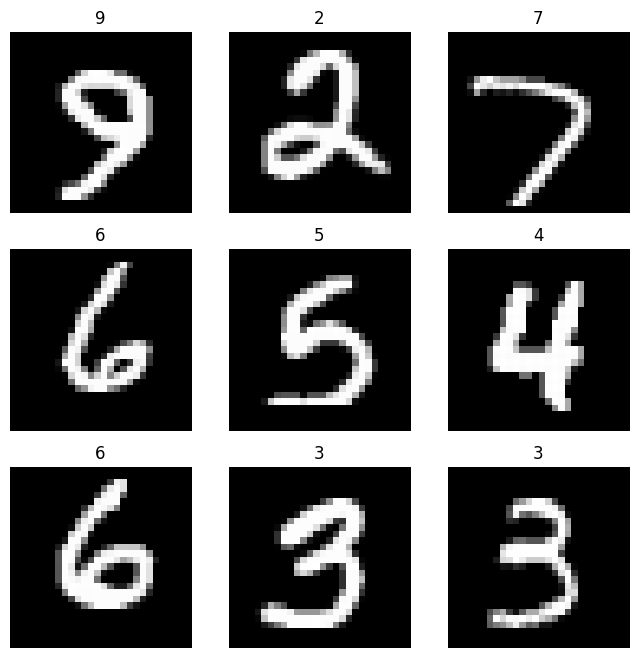

In [370]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:

generator = TestGenerator(
    topologies=[
        #two layer
        [784, 32, 16, 10],
        [784, 28, 28, 10],
        [784, 64, 32, 10],
        #three layer
        [784, 64, 32, 16, 10],
        [784, 28, 28, 28, 10],
        #four layer
        [784, 64, 32, 16, 8, 10],
        [784, 28, 28, 28, 28, 10],
    ],
    activations=[torch.tanh, torch.sigmoid],
    optimizer_params={
        'adam': {'lr': [0.002, 0.02], 'weight_decay': [0.0, 0.001]},
        'sgd': {'lr': [0.001, 0.01], 'momentum': [0.5, 0.1], 'weight_decay': [0.0, 0.001]},
        'asgd': {'lr': [0.01, 0.02], 'weight_decay': [0.0, 0.001]}
    }
)

criterion = nn.CrossEntropyLoss()


model, iter_topology, iter_activations = generator.next_model()
while model is not None:
    optimizer, iter_algo, iter_params = generator.next_optimizer(model)
    while optimizer is not None:
        num_epochs = 25
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # running_loss += loss.item()
                # if i % 100 == 99:  # print every 100 mini-batches
                #     print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
                #     running_loss = 0.0

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        activation_string = '['
        #loop through the activations skipping the first one (input layer) and the last one (output layer)
        for i in range(1, len(iter_activations)-1):
            activation_string += iter_activations[i].__name__ + ', '

        activation_string = activation_string[:-2] + ']'

        print('Accuracy:  %d %%' % (100 * correct / total))
        print('Topology:', iter_topology)
        print('Activations:', activation_string)
        print('Optimizer:', iter_algo)
        print('Params:', iter_params)

        results_file = open('results.csv', 'a')
        results_file.write(str(100 * correct / total) + ',' + str(iter_topology) + ',' + activation_string + ',' + iter_algo + ',' + str(iter_params) + '\n')
        results_file.close()
   
        iter_optimizer, iter_algo, iter_params = generator.next_optimizer(model)
    model, iter_topology, iter_activations = generator.next_model()



In [269]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { 100*(correct / total)}%')

Accuracy on test set: 92.55%


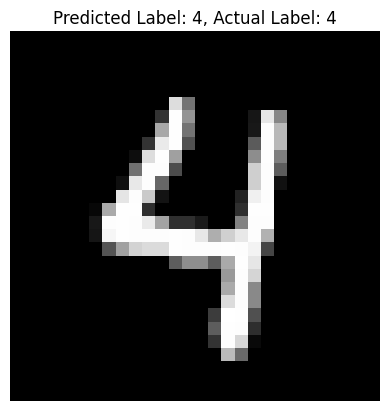

In [270]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation fucntion:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## Task - 2

### PyTorch FC ANN FMNIST Implementation


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

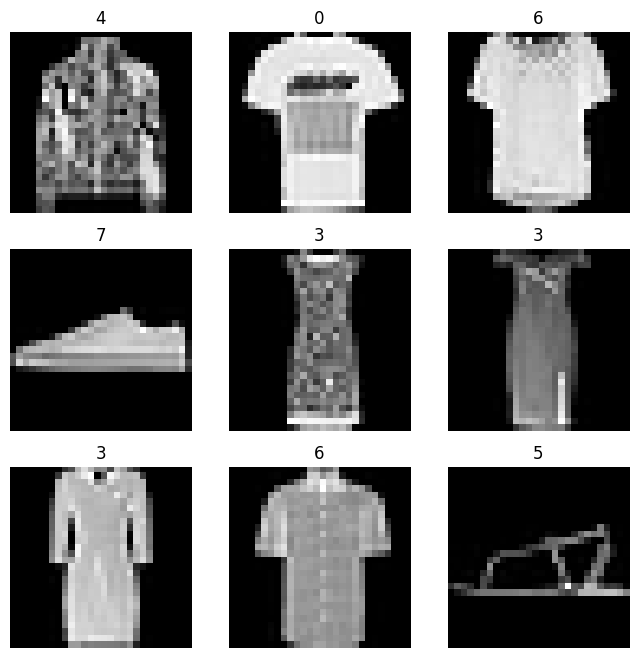

In [13]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
#Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): #MLP stands for "Multi-Layer Perceptron"
    def __init__(self): #this initializes the structure of the network
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32) ## First fully connected linear layer, 28*28 input features and 32 outputs
        self.fc2 = nn.Linear(32 , 16) ## Second fully connected linear layer, 32 inputs and 16 outputs
        self.fc3 = nn.Linear(16, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): #this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28) #the array is sent in as a vector
        x = torch.sigmoid(self.fc1(x)) ## Applying sigmoid activation for the first layer
        x = torch.tanh(self.fc2(x)) ## Applying tanh activation for the second layer
        x = self.fc3(x) ## no modifications to the activation of the output layer
        return x

# Initializing the neural network
model = MLP()

In [15]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Training the neural network
num_epochs = 9
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 2.3076939606666564
Epoch 1, Batch 200, Loss: 2.2964122533798217
Epoch 1, Batch 300, Loss: 2.283242826461792
Epoch 1, Batch 400, Loss: 2.2733342361450197
Epoch 1, Batch 500, Loss: 2.260932538509369
Epoch 1, Batch 600, Loss: 2.2505964970588686
Epoch 1, Batch 700, Loss: 2.239789249897003
Epoch 1, Batch 800, Loss: 2.226941957473755
Epoch 1, Batch 900, Loss: 2.211233465671539
Epoch 2, Batch 100, Loss: 2.190563213825226
Epoch 2, Batch 200, Loss: 2.176533591747284
Epoch 2, Batch 300, Loss: 2.1595369601249694
Epoch 2, Batch 400, Loss: 2.1390220952033996
Epoch 2, Batch 500, Loss: 2.1246925830841064
Epoch 2, Batch 600, Loss: 2.1038536286354064
Epoch 2, Batch 700, Loss: 2.082137269973755
Epoch 2, Batch 800, Loss: 2.0612794518470765
Epoch 2, Batch 900, Loss: 2.042286524772644
Epoch 3, Batch 100, Loss: 2.0021821641921997
Epoch 3, Batch 200, Loss: 1.9823235082626343
Epoch 3, Batch 300, Loss: 1.9635089230537415
Epoch 3, Batch 400, Loss: 1.9351388883590699
Epoch 3, Batch 500,

In [16]:
# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.6207%


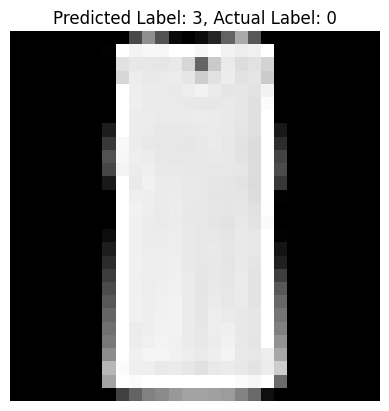

In [17]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

## PART - 3

### FMNIST CNN Implimentation with Keras

In [18]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

In [19]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [20]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [21]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [22]:
model = Sequential([
    Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)),  # 16 filters (reduced), 3x3 kernel
    MaxPooling2D(pool_size=(5, 5)),  # Max pooling with 2x2 pool size
    # Flatten the output before passing to Dense layers
    Flatten(),
    Dense(64, activation='softmax'),  # Reduced from 128 to 64 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

## change the architecture with CONV2D, Pooling, and Dense.

/Users/thomasjones/.pyenv/versions/3.10.15/envs/MLExp/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-14 04:31:08.036516: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Ultra
2024-10-14 04:31:08.036554: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-10-14 04:31:08.036560: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-10-14 04:31:08.036575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-14 04:31:08.036587: I tensorflow/core/common_runtime/pluggabl

In [23]:
learning_rate = 0.01
epochs = 5
batch_size = 48

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5


2024-10-14 04:31:08.517806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1028 - loss: 2.3025
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1085 - loss: 2.3024
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1058 - loss: 2.3023
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1110 - loss: 2.3022
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1178 - loss: 2.3021
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0961 - loss: 2.3019
Test accuracy: 0.0997999981045723


In [25]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1254 - loss: 2.3019 - val_accuracy: 0.0948 - val_loss: 2.3018
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1136 - loss: 2.3018 - val_accuracy: 0.0978 - val_loss: 2.3017
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1152 - loss: 2.3017 - val_accuracy: 0.0958 - val_loss: 2.3016
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1226 - loss: 2.3015 - val_accuracy: 0.1462 - val_loss: 2.3015
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1231 - loss: 2.3013 - val_accuracy: 0.0965 - val_loss: 2.3012
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0989 - loss: 2.3012
Test accuracy: 0.10080000013113022


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


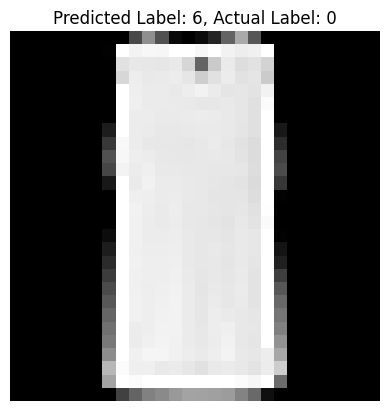

In [26]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

### Just to explore TensorFlow Implemenation of CNN.

Not Required For Submission.

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1009 - loss: 2.3027
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1013 - loss: 2.3026
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1046 - loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1025 - loss: 2.3025
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1051 - loss: 2.3025
313/313 - 2s - 5ms/step - accuracy: 0.1003 - loss: 2.3024

Test accuracy: 0.10029999911785126


## AUTOMATED TUNING (EXETENDED)

In [28]:
# https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams